## A note book to review and summarize QC metrics for HRApop v1.0

## Install and import libraries

In [100]:
%pip install requests pandas seaborn duckdb matplotlib scanpy numpy

import os
import requests
import zipfile
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scanpy as sc
import numpy as np

Note: you may need to restart the kernel to use updated packages.


## Load data

In [101]:
url = "https://zenodo.org/records/17781640/files/hra-pop-v1.0-qc.zip?download=1"

folder_path = "data"
os.makedirs(folder_path, exist_ok=True)

zip_name = "hra-pop-v1.0-qc.zip"
file_path = f"{folder_path}/{zip_name}"

if not os.path.exists(file_path):
    print("Downloading…")
    r = requests.get(url, allow_redirects=True)
    with open(file_path, "wb") as f:
        f.write(r.content)
    print(f"File downloaded and saved at {file_path}")
else:
    print(f"File already exists at {file_path}")

File already exists at data/hra-pop-v1.0-qc.zip


In [102]:
def unzip_if_needed(zip_path: str, extract_dir: str) -> None:
    """Unzip a ZIP file only if it hasn't been extracted yet."""
    if os.path.exists(extract_dir) and os.listdir(extract_dir):
        print(f"⚙️ Already unzipped — skipping extraction: {extract_dir}")
        return

    print(f"📦 Extracting {zip_path} ...")
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Files extracted to: {extract_dir}")



zip_path = "data/hra-pop-v1.0-qc2.zip"
extract_dir = "data/unzipped"
unzip_if_needed(zip_path, extract_dir)

⚙️ Already unzipped — skipping extraction: data/unzipped


In [103]:
"""
D CREATE TABLE qc AS SELECT * FROM read_json('qc/*/qc_results/qc_summary.json', union_by_name = true, filename = true );
D .schema qc
CREATE TABLE qc(input_file VARCHAR, total_cells BIGINT, low_quality_cells BIGINT, percent_low_quality DOUBLE, mean_pct_counts_mt DOUBLE, mean_pct_counts_ribo DOUBLE, thresholds STRUCT(min_genes BIGINT, max_genes BIGINT, max_mt DOUBLE, min_ribo JSON, mt_prefix VARCHAR, ribo_prefixes VARCHAR[]), files STRUCT(qc_per_cell_csv VARCHAR, qc_summary_csv VARCHAR), filename VARCHAR);
"""

"\nD CREATE TABLE qc AS SELECT * FROM read_json('qc/*/qc_results/qc_summary.json', union_by_name = true, filename = true );\nD .schema qc\nCREATE TABLE qc(input_file VARCHAR, total_cells BIGINT, low_quality_cells BIGINT, percent_low_quality DOUBLE, mean_pct_counts_mt DOUBLE, mean_pct_counts_ribo DOUBLE, thresholds STRUCT(min_genes BIGINT, max_genes BIGINT, max_mt DOUBLE, min_ribo JSON, mt_prefix VARCHAR, ribo_prefixes VARCHAR[]), files STRUCT(qc_per_cell_csv VARCHAR, qc_summary_csv VARCHAR), filename VARCHAR);\n"

In [104]:
data_dir = "data/unzipped"

# 1. Create the table from JSON files
query = f"""
CREATE OR REPLACE TABLE qc AS
WITH qc_data AS (
    SELECT
        *,
        regexp_extract(filename, '.*/qc/([^/]+)/qc_results/.*', 1) AS folder_name
    FROM read_json('{data_dir}/qc/*/qc_results/qc_summary.json',
                   union_by_name = true,
                   filename = true)
),
datasets AS (
    SELECT
        regexp_extract(filename, '.*/qc/([^/]+)/dataset.json', 1) AS folder_name,
        dataset_id
    FROM read_json('{data_dir}/qc/*/dataset.json',
                   union_by_name = true,
                   filename = true)
)
SELECT 
    q.*,
    d.dataset_id
FROM qc_data q
LEFT JOIN datasets d USING (folder_name);
"""

# Run the query
duckdb.sql(query)

# ✅ Load the table into a Pandas DataFrame
df_qc = duckdb.sql("SELECT * FROM qc").df()

# 2. Export results to CSV
duckdb.sql(
    f"""
COPY qc TO '{data_dir}/cell-instances.csv.gz' (FORMAT CSV, HEADER, COMPRESSION GZIP);
"""
)

# 3. Optionally show a preview
print("\n🔍 Preview:")
duckdb.sql("SELECT * FROM qc LIMIT 10;").show()

# 4. Verify DataFrame content
print("\n📊 DataFrame loaded with shape:", df_qc.shape)
print(df_qc.head())


🔍 Preview:
┌────────────────────────────────────────────────────────────────┬─────────────┬───────────────────┬─────────────────────┬────────────────────────┬───────────────────┬─────────────────────────────────┬─────────────────────────────────┬────────────────────┬──────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────┬──────────────────────────┬───────────────────────────────────────────────────────────────────────────────────┐
│                           input_file                           │ total_cells │ low_quality_cells │ percent_low_quality │ mean_n_genes_by_counts │ mean_total_counts │ mean_pct_counts_in_top_20_genes │ mean_pct_counts_in_top_50_genes │ mean_pct_counts_mt │ mean_pct

In [105]:
df_qc

,input_file,total_cells,low_quality_cells,percent_low_quality,mean_n_genes_by_counts,mean_total_counts,mean_pct_counts_in_top_20_genes,mean_pct_counts_in_top_50_genes,mean_pct_counts_mt,mean_pct_counts_ribo,thresholds,files,filename,folder_name,dataset_id
0,/var/lib/cwl/stg45216f3e-5096-4e70-aca6-869502...,1502,0,0.00,725.921,1678.682,5.527,12.406,0.000,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/GTEX-15CHR-5014-SM-H5JDU/qc_r...,GTEX-15CHR-5014-SM-H5JDU,https://doi.org/10.1126/science.abl4290#GTEX-1...
1,/var/lib/cwl/stgce528fd6-e789-4394-904c-ad73ac...,11633,11397,97.97,638.537,1526.441,39.528,55.113,22.123,18.789,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM232.MLHJ.832/qc_results/qc...,HBM232.MLHJ.832,https://entity.api.hubmapconsortium.org/entiti...
2,/var/lib/cwl/stg44514c74-1195-48c4-8224-3904af...,27278,19402,71.13,635.724,696.479,25.812,39.877,7.919,5.133,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM248.HPXX.584/qc_results/qc...,HBM248.HPXX.584,https://entity.api.hubmapconsortium.org/entiti...
3,/var/lib/cwl/stg8a655d22-52eb-4e22-9b13-88cfbf...,1999,329,16.46,5655.002,15273.749,7.933,11.923,0.113,1.101,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM265.PCGD.229/qc_results/qc...,HBM265.PCGD.229,https://entity.api.hubmapconsortium.org/entiti...
4,/var/lib/cwl/stgcabe31fd-d8f5-455d-b69b-0d86e0...,19243,724,3.76,869.155,948.120,13.906,22.243,1.399,5.697,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM293.NNSQ.773/qc_results/qc...,HBM293.NNSQ.773,https://entity.api.hubmapconsortium.org/entiti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,/var/lib/cwl/stg44c39e4a-e221-460a-a1d5-9f39e8...,6636,0,0.00,940.864,847.608,6.019,12.495,0.219,0.287,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...
554,/var/lib/cwl/stg2373221c-c499-40a0-a04d-515f48...,9035,0,0.00,1265.002,896.775,5.719,11.484,0.304,0.339,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...
555,/var/lib/cwl/stgd2487083-c5c6-48ea-95a0-3cb1a9...,6883,0,0.00,1378.483,954.716,5.288,10.682,0.306,0.339,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...
556,/var/lib/cwl/stgd1abac39-2083-4351-b9b6-58c2d1...,872,1,0.11,2403.356,2909.846,3.224,6.700,2.352,5.601,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...


In [106]:
df_qc.columns

Index(['input_file', 'total_cells', 'low_quality_cells', 'percent_low_quality',
       'mean_n_genes_by_counts', 'mean_total_counts',
       'mean_pct_counts_in_top_20_genes', 'mean_pct_counts_in_top_50_genes',
       'mean_pct_counts_mt', 'mean_pct_counts_ribo', 'thresholds', 'files',
       'filename', 'folder_name', 'dataset_id'],
      dtype='object')

## Preprocess before visualizing

In [107]:
# Load Sankey CSV to add organ name
df_sankey = pd.read_csv(
    "https://raw.githubusercontent.com/x-atlas-consortia/hra-pop/refs/heads/main/output-data/v1.0/reports/universe-ad-hoc/sankey.csv"
)[["organ_name", "dataset_id", "portal"]]

df_sankey

/var/folders/x7/ttglg94d4g500ypbdkw3__nw0000gq/T/ipykernel_12655/3690142819.py:2: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sankey = pd.read_csv(


,organ_name,dataset_id,portal
0,small intestine,hhttps://api.cellxgene.cziscience.com/dp/v1/co...,HCA
1,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,KPMP
2,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,KPMP
3,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,KPMP
4,mesenteric lymph node,http://purl.org/ccf/1.5/omap-1#Donor1_TissueBl...,HRA
...,...,...,...
22189,heart,https://sparc.science/datasets/390/version/1?d...,SPARC
22190,heart,https://sparc.science/datasets/390/version/1?d...,SPARC
22191,heart,https://sparc.science/datasets/390/version/1?d...,SPARC
22192,left kidney,https://zenodo.org/records/7653239#Donor1_Tiss...,KPMP


In [108]:
df_merged = df_qc.merge(df_sankey, on="dataset_id", how="inner")

## Get mean, median, standard deviation

In [109]:
qc_table_merged = (
    df_merged.groupby("organ_name")
    .agg(
        {
            # columns with mean, median, std
            "mean_pct_counts_ribo": ["mean", "median", "std"],
            "mean_pct_counts_mt": ["mean", "median", "std"],
            # columns where you want ONLY mean
            "mean_n_genes_by_counts": ["mean"],
            "mean_total_counts": ["mean"],
            "mean_pct_counts_in_top_20_genes": ["mean"],
            "mean_pct_counts_in_top_50_genes": ["mean"],
        }
    )
    .reset_index()
)

# Flatten columns
qc_table_merged.columns = [
    (
        "Organ name"
        if col[0] == "organ_name"
        else (
            f"{col[0]}"
            if col[1] == "mean"
            and col[0].startswith("mean_")
            and col[0] not in ["mean_pct_counts_ribo", "mean_pct_counts_mt"]
            else f"{col[0]}_{col[1]}"
        )
    )
    for col in qc_table_merged.columns
]

# Rename to readable names
qc_table_merged = qc_table_merged.rename(
    columns={
        # ribosomal stats
        "mean_pct_counts_ribo_mean": "Mean % ribosomal genes",
        "mean_pct_counts_ribo_median": "Median % ribosomal genes",
        "mean_pct_counts_ribo_std": "SD % ribosomal genes",
        # mitochondrial stats
        "mean_pct_counts_mt_mean": "Mean % mitochondrial genes",
        "mean_pct_counts_mt_median": "Median % mitochondrial genes",
        "mean_pct_counts_mt_std": "SD % mitochondrial genes",
        # mean-only columns
        "mean_n_genes_by_counts": "Mean number of genes with positive counts",
        "mean_total_counts": "Mean total number of genes",
        "mean_pct_counts_in_top_20_genes": "% of counts for 20 most expressed genes",
        "mean_pct_counts_in_top_50_genes": "% of counts for 50 most expressed genes",
    }
)

# Capitalize organ names
qc_table_merged["Organ name"] = qc_table_merged["Organ name"].str.capitalize()

# Round final table
qc_table_merged = qc_table_merged.round(6)

qc_table_merged

,Organ name,Mean % ribosomal genes,Median % ribosomal genes,SD % ribosomal genes,Mean % mitochondrial genes,Median % mitochondrial genes,SD % mitochondrial genes,Mean number of genes with positive counts,Mean total number of genes,% of counts for 20 most expressed genes,% of counts for 50 most expressed genes
0,Set of lactiferous glands in left breast,5.608000,5.6080,0.237588,1.227000,1.2270,0.192333,3346.585000,3387.702000,2.567000,5.686000
1,Set of lactiferous glands in right breast,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,658.067333,1706.838000,5.100333,11.702000
2,Heart,1.910315,0.7950,2.296890,1.133288,0.7510,1.108084,1154.918946,1114.928000,20.405297,26.367613
3,Large intestine,1.901851,1.0600,1.685545,2.267064,1.4160,3.069808,1702.504234,2855.922383,24.662426,32.965426
4,Left kidney,2.704413,3.1760,1.964139,7.073109,6.5270,4.678221,1057.325196,2077.369989,34.451478,46.355250
5,Left ureter,5.298308,4.2200,3.309310,3.551000,1.7710,3.614714,1791.867231,3225.290462,14.325231,21.706615
6,Liver,0.442500,0.4425,0.348142,4.368000,4.3680,0.862561,1431.246000,2491.348500,18.289000,26.159500
7,Male reproductive system,1.746333,0.0000,2.846618,0.383667,0.0000,0.595625,1763.145333,2469.973333,3.874167,8.672333
8,Pancreas,3.772000,3.7720,0.909219,1.796000,1.7960,0.555391,3755.175000,3327.740000,2.983000,6.002000
9,Respiratory system,1.468598,0.6845,2.854915,7.654228,4.2700,10.993554,1344.932522,3095.898826,30.152576,39.994685


In [110]:
qc_table_merged.to_csv("output/qc_table.csv", index=False, float_format="%.5f")

# Violin plot for ribo and mito 

In [111]:
df_merged.columns

Index(['input_file', 'total_cells', 'low_quality_cells', 'percent_low_quality',
       'mean_n_genes_by_counts', 'mean_total_counts',
       'mean_pct_counts_in_top_20_genes', 'mean_pct_counts_in_top_50_genes',
       'mean_pct_counts_mt', 'mean_pct_counts_ribo', 'thresholds', 'files',
       'filename', 'folder_name', 'dataset_id', 'organ_name', 'portal'],
      dtype='object')

In [112]:
df_merged.head()

,input_file,total_cells,low_quality_cells,percent_low_quality,mean_n_genes_by_counts,mean_total_counts,mean_pct_counts_in_top_20_genes,mean_pct_counts_in_top_50_genes,mean_pct_counts_mt,mean_pct_counts_ribo,thresholds,files,filename,folder_name,dataset_id,organ_name,portal
0,/var/lib/cwl/stg45216f3e-5096-4e70-aca6-869502...,1502,0,0.00,725.921,1678.682,5.527,12.406,0.000,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/GTEX-15CHR-5014-SM-H5JDU/qc_r...,GTEX-15CHR-5014-SM-H5JDU,https://doi.org/10.1126/science.abl4290#GTEX-1...,male reproductive system,GTEx
1,/var/lib/cwl/stgce528fd6-e789-4394-904c-ad73ac...,11633,11397,97.97,638.537,1526.441,39.528,55.113,22.123,18.789,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM232.MLHJ.832/qc_results/qc...,HBM232.MLHJ.832,https://entity.api.hubmapconsortium.org/entiti...,spleen,HuBMAP
2,/var/lib/cwl/stg44514c74-1195-48c4-8224-3904af...,27278,19402,71.13,635.724,696.479,25.812,39.877,7.919,5.133,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM248.HPXX.584/qc_results/qc...,HBM248.HPXX.584,https://entity.api.hubmapconsortium.org/entiti...,left kidney,HuBMAP
3,/var/lib/cwl/stg8a655d22-52eb-4e22-9b13-88cfbf...,1999,329,16.46,5655.002,15273.749,7.933,11.923,0.113,1.101,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM265.PCGD.229/qc_results/qc...,HBM265.PCGD.229,https://entity.api.hubmapconsortium.org/entiti...,small intestine,HuBMAP
4,/var/lib/cwl/stg8a655d22-52eb-4e22-9b13-88cfbf...,1999,329,16.46,5655.002,15273.749,7.933,11.923,0.113,1.101,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM265.PCGD.229/qc_results/qc...,HBM265.PCGD.229,https://entity.api.hubmapconsortium.org/entiti...,small intestine,HuBMAP


In [113]:
# prep df
df = df_merged.rename(
    columns={
        "organ_name": "Organ Name",
        "mean_pct_counts_mt": "percent.mito",
        "mean_pct_counts_ribo": "percent.ribo",
        "mean_n_genes_by_counts": "nFeature_RNA",
        "mean_total_counts": "nCount_RNA",
    }
).copy()

# convert fractions → percent if needed
for col in ["percent.mito", "percent.ribo"]:
    if df[col].max() <= 1.01:
        df[col] = df[col] * 100

df["Organ Name"] = df["Organ Name"].str.replace(
    r".*in\s+(left breast|right breast)$", r"\1", regex=True
)

In [114]:
def make_violin_plot(data, x, y, x_label, y_label, title, save=True):
    plt.figure(figsize=(5, 5))
    order = sorted(data[x].unique())
    palette = sns.color_palette("Set2", n_colors=len(order))

    sns.violinplot(
        data=data,
        x=x,
        y=y,
        order=order,
        cut=0,
        inner=None,
        linewidth=1,
        hue=x,
        palette=palette,
    )

    #     sns.boxplot(
    #     data=data,
    #     x=x,
    #     y=y,
    #     order=order,
    #     width=0.2,
    #     showcaps=True,
    #     boxprops={'facecolor': 'none', 'linewidth': 1},
    #     whiskerprops={'linewidth': 1},
    #     medianprops={'color': 'black', 'linewidth': 1.5},
    #     showfliers=False,
    # )

    sns.stripplot(
        data=data,
        x=x,
        y=y,
        color="black",
        size=2,
        alpha=0.8,
        order=order,
        jitter=0.2,
    )

    plt.xticks(rotation=90, ha="right")
    plt.ylabel(y_label, size=13)
    plt.xlabel(x_label, size=13)
    plt.title(title, size=13, fontweight="bold")
    plt.tight_layout()

    if save:
        plt.savefig(
            f"output/{title.replace(' ', '_').lower()}_violin_plot.png", dpi=300
        )

    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    plt.show()

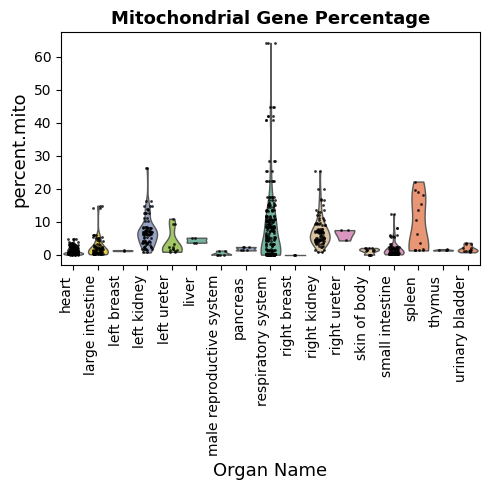

In [115]:
make_violin_plot(df, "Organ Name", "percent.mito", "Organ Name", "percent.mito", "Mitochondrial Gene Percentage")

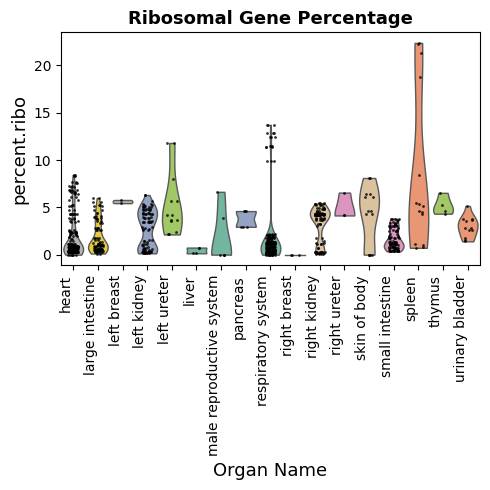

In [116]:
make_violin_plot(
    df,
    "Organ Name",
    "percent.ribo",
    "Organ Name",
    "percent.ribo",
    "Ribosomal Gene Percentage",
)

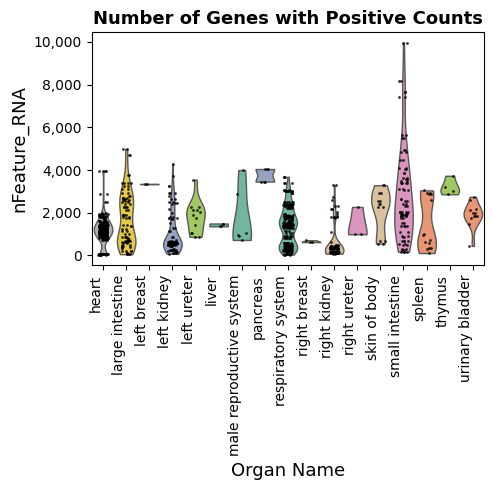

In [117]:
make_violin_plot(
    data=df,
    x="Organ Name",
    y="nFeature_RNA",
    x_label="Organ Name",
    y_label="nFeature_RNA",
    title="Number of Genes with Positive Counts")

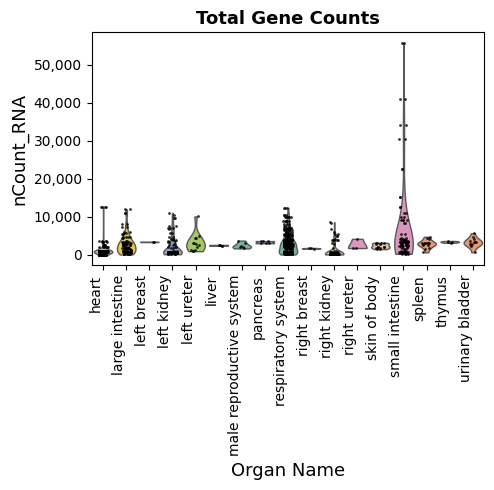

In [118]:
make_violin_plot(
    data=df,
    x="Organ Name",
    y="nCount_RNA",
    x_label="Organ Name",
    y_label="nCount_RNA",
title="Total Gene Counts")